In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
import pandas as pd
from lib.preprocessing_data import Preprocessing


# data_set = pd.read_csv('../data/preprocessed_data/lemmatized_with_stopwords_removed.csv')

data_set = Preprocessing().lemmatization_with_stopwords_removal(pd.read_csv('../data/raw_splits/train.csv'))
processed_tweetss = data_set['processed_tweets'][:150]



/home/hasabir/miniconda3/envs/ai/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
[nltk_data] Downloading package words to /home/hasabir/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
# Create vocabulary

vocab = set(word for tweet in processed_tweetss for word in tweet)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)


In [5]:
# Initialize embeddings

import numpy as np
embedding_size = 50
learning_rate = 0.1
main_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_size))
context_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_size))


In [12]:
# Numerically stable sigmoid function
def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

In [13]:
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

In [14]:
# Sample negative examples based on word frequencies.

def get_negative_samples(vocab_size, exclude_idx, num_samples, word_freq):
    probabilities = np.array([freq ** 0.75 for freq in word_freq])
    probabilities /= probabilities.sum()

    negative_samples = []
    while len(negative_samples) < num_samples:
        sampled_idx = np.random.choice(vocab_size, p=probabilities)
        if sampled_idx != exclude_idx:
            negative_samples.append(sampled_idx) 
    return negative_samples

In [15]:
# Update embeddings for one main-context pair

def update_embeddings(main_idx, context_idx, label):
    main_vector = main_embeddings[main_idx]
    context_vector = context_embeddings[context_idx]

    dot_product = np.dot(main_vector, context_vector)
    prediction = sigmoid(dot_product)
    error = label - prediction

    # Gradient updates
    grad_main = error * context_vector
    grad_context = error * main_vector

    main_embeddings[main_idx] += learning_rate * grad_main
    context_embeddings[context_idx] += learning_rate * grad_context

In [16]:
def plot_words2(word1, word2, word_to_index, main_embeddings, context_embeddings):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import cosine

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    vector1_main = main_embeddings[word_to_index[word1]]
    vector2_main = main_embeddings[word_to_index[word2]]

    plt.scatter(vector1_main[0], vector1_main[1], color='red', label=word1)
    plt.arrow(0, 0, vector1_main[0], vector1_main[1], color='red', head_width=0.00)

    plt.scatter(vector2_main[0], vector2_main[1], color='blue', label=word2)
    plt.arrow(0, 0, vector2_main[0], vector2_main[1], color='blue', head_width=0.00)

    similarity_main = 1 - cosine(vector1_main, vector2_main)
    plt.title(f"Main Embeddings (Sim = {round(similarity_main, 4)})", fontsize=12)

    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.grid()

    plt.xlim(-0.2, 0.2)
    plt.ylim(-0.2, 0.2)

    
    plt.legend()

    plt.tight_layout()
    plt.show()


In [17]:
# extract three most frequent pairs

from collections import Counter
from itertools import combinations


sentiment_pairs = {'positive': [], 'negative': [], 'neutral': []}

for sentiment, processed_tweets in zip(data_set['sentiment'], data_set['processed_tweets']):
    pairs = list(combinations(processed_tweets, 2))
    sentiment_pairs[sentiment].extend(pairs)

frequent_pairs = {}
for sentiment, pairs in sentiment_pairs.items():
    pair_counts = Counter(pairs)
    frequent_pairs[sentiment] = pair_counts.most_common(3) 


for sentiment, pairs in frequent_pairs.items():
    print(f"{sentiment.upper()} SENTIMENT:")
    for pair, count in pairs:
        print(f"  Pair: {pair}, Count: {count}")



POSITIVE SENTIMENT:
  Pair: ('thank', 'happy'), Count: 189
  Pair: ('follow', 'happy'), Count: 139
  Pair: ('recent', 'happy'), Count: 129
NEGATIVE SENTIMENT:
  Pair: ('not', 'unhappy'), Count: 71
  Pair: ('do', 'not'), Count: 60
  Pair: ('I', 'm'), Count: 60
NEUTRAL SENTIMENT:
  Pair: ('also', 'epaper'), Count: 42
  Pair: ('supreme', 'court'), Count: 19
  Pair: ('chief', 'minister'), Count: 11


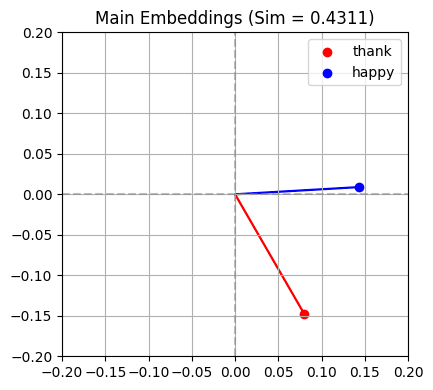

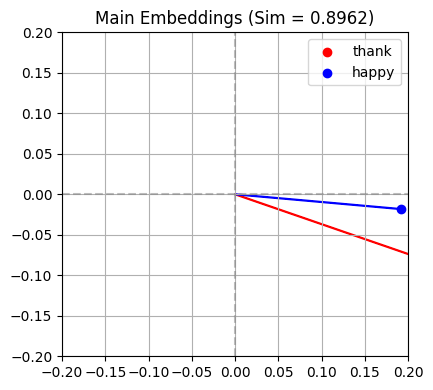

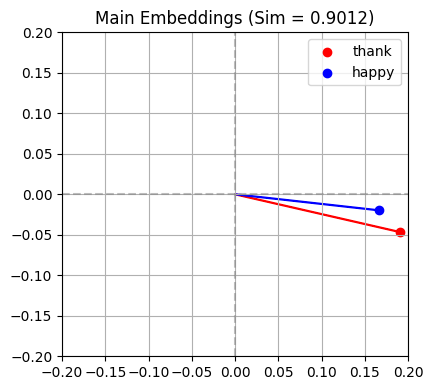

In [18]:

word_counts = Counter(word for tweet in processed_tweetss for word in tweet)
word_freq = np.array([word_counts[word] for word in vocab])

epochs = 10
window_size = 3
num_negative_samples=3

for epoch in range(epochs):
    for tweet in processed_tweetss:
        for main_idx, main_word in enumerate(tweet):
            main_word_idx = word_to_idx[main_word]
            start = max(main_idx - window_size, 0)
            end = min(main_idx + window_size + 1, len(tweet))

            for context_idx in range(start, end):
                if main_idx == context_idx:
                    continue
                context_word_idx = word_to_idx[tweet[context_idx]]

                # Positive sample
                update_embeddings(main_word_idx, context_word_idx, 1)
                # Negative samples
                negative_samples = get_negative_samples(vocab_size, main_word_idx, num_negative_samples, word_freq)
                for negative_idx in negative_samples:
                    update_embeddings(main_word_idx, negative_idx, 0)

    main_embeddings = normalize_embeddings(main_embeddings)
    context_embeddings = normalize_embeddings(context_embeddings)

    if epoch % 5 == 0:
        plot_words2('thank', 'happy', word_to_idx, main_embeddings, context_embeddings)

plot_words2('thank', 'happy', word_to_idx, main_embeddings, context_embeddings)



In [ ]:
from lib.word2vec import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_df = Preprocessing().lemmatization_with_stopwords_removal(pd.read_csv('../data/raw_splits/train.csv'))
test_df = Preprocessing().lemmatization_with_stopwords_removal(pd.read_csv('../data/raw_splits/test.csv'))

X_train = train_df['processed_tweets']
X_test = test_df['processed_tweets']

y_train = train_df['label'].to_numpy().astype(int)
y_test = test_df['label'].to_numpy().astype(int)

vectorizer = Word2Vec(X_train, 50)
X_train_vector = vectorizer.word2vec()
X_test_vector = vectorizer.word2vec()

model = LogisticRegression()

model.fit(X_train_vector, y_train)
y_pred = model.predict(X_test_vector)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Word to vec: {accuracy}")

